In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.integrate import odeint
from sympy import *
init_printing(use_unicode=False, wrap_line=True)

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

# Expansion to hexapole order

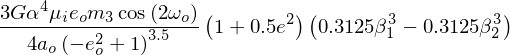

In [2]:
m1, m2, a_i, a_o, e_i, e_o, m3, G, mu_i, alpha, mu_o = \
symbols(r"m_1, m_2, a_i, a_o, e_i, e_o, m_3, G, \mu_i, \alpha, \mu_o", positive=True, real=True)

w_i, w_o, m12, m123, nu_i, nu_o, beta1, beta2, omega_o = \
    symbols(r"\omega_i, \omega_o, m_{12}, m_{123}, n_i, n_o, \beta_1 \beta_2 \omega_o", real=True)

j, m, l, k = symbols('j m l k', real=True, interger=True)
    
def hansen_inner(l, m):
    expr = ((l - m + 1)/2 - k)*((l - m)/2 - k)/((m + k + 1)*(k + 1))*exp(2*j)
    h_i = 1 + Sum(Product(expr, (k, 0, j - 1)), (j, 1, (l - m)/2))
    return h_i

def hansen_outer(l, m):
    a = e_o/2**m*(1 - e_o**2)**(-(2*l - 1)/2)
    summand = binomial(l - 1, 2*j + m)*binomial(2*j + m, j)*(e_o**2/2)**j
    return a*Sum(summand, (j, 0, floor((l - m - 1)/2))).doit()
                                                

M_l = lambda l: beta1**(l - 1) - beta2**(l - 1)
clm_sq = lambda l, m: factorial(l - m)*factorial(l + m)/(2**(2*l - 1)\
    *(factorial((l + m)/2)*factorial((l - m)/2))**2)
    

hex_term = clm_sq(4, 2)*M_l(4)*alpha**4*hansen_inner(4,2)*hansen_outer(4, 2)
hex_term = hex_term.doit()*cos(2*omega_o)*G*mu_i*m3/a_o
hex_term

In [3]:
# Lagrange equation
eodot_hex = -sqrt(1- e_o**2)/(mu_o*nu_o*e_o*a_o**2)*diff(hex_term, omega_o)
wodot_hex = sqrt(1- e_o**2)/(mu_o*nu_o*e_o*a_o**2)*diff(hex_term, e_o)

# Fixed points of the secular equations

The fixed points are given by the solution of the following equations

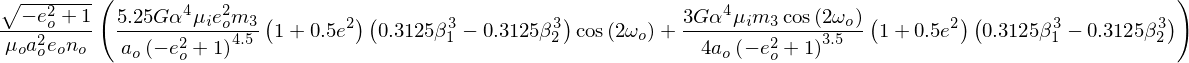

In [4]:
w_o_dot = nu_o*m1*m2/m12**2*(3*alpha**2/4*(1 + 3*e_i**2/2)/(1 - e_o**2)**2\
        -15*(m1 - m2)/m12*alpha**3*(1 + 3*e_i**2/4)*e_i/e_o*(1 + 4*e_o**2)/\
        (1 - e_o**2)**3*cos(w_o)/16) + wodot_hex

e_o_dot = nu_o*15*m1*m2/m12**2*(m1 - m2)/m12*alpha**3*e_i*(1 + 3*e_i**2/4)/\
        (1 - e_o**2)**2*sin(w_o)/16 + eodot_hex
    
w_o_dot = w_o_dot.subs({beta1: m2/m12,
                      beta2: -m2/m12})
e_o_dot = e_o_dot.subs({beta1: m2/m12,
                      beta2: -m2/m12})

w_o_dot = w_o_dot.subs({omega_o: 0})
wodot_hex
# solv = solve(w_o_dot, e_i)

The first equation can only be satisfied if $q=1$ or $\omega_o=\{0, \phi\}$. We choose
$q\neq 1$, therefore, the second equation reduces to

### Finding zeroes
The easiest way to find the solution is to plot $\dot{\omega_o}$ as a function of $e_0$.

In [ ]:
from scipy.optimize import root

# Parameter values:
n = np.linspace(1, 6.5, 100)
roots = np.zeros(100)
    
for i, p in enumerate(n):
    m1_ = 1.2
    m2_ = 1.2*0.6
    m3_ = 1e-03
    nu_i_ = 2*np.pi/(20/365.25)
    nu_o_ = 2*np.pi/((20/365.25)*p)
    e_i_ = 0.3
    P_o = (p*20/365.25)

    # ratio of semi-major axes from Kepler's third law
    alpha_ = ((m1_ + m2_)/(m1_ + m2_ + m3_))**(1/3.)*(nu_o_/nu_i_)**(2/3.)

    m12_ = m1_ + m2_
    m123_ = m1_ + m2_ + m3
    mu_o_ = m12*m3/m123
    mu_i_ = m1*m2/m12
    beta_1 = m1/m12
    beta_2 = -m1/m12
    a_o_ = P_o**(2/3)*m123**(1/3)
    
    A = nu_o_*(m1_*m2_/m12_**2)*(3/4)*alpha_**2*(1 + 3**e_i_**2/2),
    B = nu_o_*(m1_*m2_/m12_**2)*(15/16)*((m1_ - m2_)/m12_)*alpha_**3*(1 + 3*e_i_**2/4)*e_i_

    e_o_ = np.linspace(0, 1, 1000)

    omega_dot_ = A*(1 - e_o_**2)**(-2) - B*(1 + 4*e_o_**2)/(e_o_*(1 - e_o_**2)**3) 
    
    hex_term_ad = np.sqrt(-e_o_**2 + 1)*(5.25*4*np.pi**2*alpha_**4*mu_i_*e_o_**2*m3_*\
    (1 + 0.5*exp(2))*(0.3125*beta_1**3 - 0.3125*beta_2**3)*(-e_o_**2 + 1)**(-4.5)\
    /a_o + 3*4*np.pi**2*alpha_**4*mu_i_*m3_*(1 + 0.5*np.exp(2))*(0.3125*beta_1**3 - 0.3125*beta_2**3)*(-e_o_**2 + 1)**(-3.5)/(4*a_o_))/\
    (mu_o_*a_o_**2*e_o_*nu_o_)
    
    omega_dot_ = omega_dot_ + hex_term_ad

    #Find roots numerically

    function = lambda e_o_: A/(1 - e_o_**2)**(2) - B*(1 + 4*e_o_**2)/(e_o_*(1 - e_o_**2)**3)

    result = root(function, [0.1])

    roots[i] = result.x[0]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(n, roots)
ax.set_ylim(0, 0.3)
ax.set_xlabel(r'$P_o/P_i$')
ax.set_ylabel(r'$e_{forced}$')
ax.grid(True)

/home/fran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in power
/home/fran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/fran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in subtract
/home/fran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in power


In [ ]:
print(roots[-1])

It appears that there is a root at about 0.03 and another one at around 0.9 at $\omega_o=0$ and $P_o/P_i=5.5$ , at $\omega_o=\pi$ there are no real roots. Let's try to solve the equation using
Sympy.

In [ ]:
A, B, alpha = symbols(r'A B \alpha', real=True, positive=True)
omega_dot = A*(1 - e_o**2)**(-2) - B*(1 + 4*e_o**2)/(e_o*(1 - e_o**2)**3)
solution = solve(omega_dot, e_o)
solution[0]

In [ ]:
solution[0].subs({
    A: 0.001650118716251345,
    B: 4.644470964702057e-05
})

print(alpha_)

In [ ]:
def lagrange_equations(var, t, params):
    """
    Defines the differential equations for the secular evolution of 
    a three body system.
    
    Arguments:
        var :  vector of the state variables:
                  var = [e_i, w_i, e_o, w_o]
        t :  time
        params :  vector of the parameters:
                  params = [m1, m2, m3, nu_i, nu_o, a_i, alpha]
    """
    e_i, w_i, e_o, w_o = var
    m1, m2, m3, nu_i, nu_o, alpha = params
    m12 = m1 + m2
    # Calculate derivatives
    f = np.array([
        -nu_i*(15/16.)*(m3/m12)*(m1 - m2)/m12*alpha**4*e_o*\
        (1 + 3/4*e_i**2)*(1 - e_i**2)**.5/(1 - e_o**2)**2.5*np.sin(w_i - w_o),
        
        nu_i*m3/m12*(3/4*alpha**3*(1 - e_i**2)**.5/(1 - e_o**2)**(3/2.) -\
        15/16.)*(m1 - m2)/m12*alpha**4*e_o*(1 + 9/4*e_i**2)*(1 - e_i**2)**.5/\
        e_i*(1 - e_o**2)**2.5*np.cos(w_i - w_o),
        
        nu_o*15/16.*m1*m2/m12**2*(m1 - m2)/m12*alpha**3*e_i*(1 + 3/4.*e_i**2)/\
        (1 - e_o**2)**2*np.sin(w_i - w_o),
        
        nu_o*m1*m2/m12**2*(3/4.*alpha**2*(1 + 3/2.*e_i**2)/(1 - e_o**2)**2 -\
        15/16.*(m1 - m2)/m12*alpha**3*(1 + 3/4.*e_i**2)*e_i/e_o*(1 + 4*e_o**2)/\
        (1 - e_o**2)**3*np.cos(w_i - w_o))
    ])
    return f

# Parameter values:
m1_ = 1.2
m2_ = 0.6*1.2
m3_ = 1e-03
nu_i_ = 2*np.pi/20
nu_o_ = 2*np.pi/(20*5.5)

# ratio of semi-major axes from Kepler's third law
alpha_ = ((m1_ + m2_)/(m1_ + m2_ + m3_))**(1/3.) * (nu_o_/nu_i_)**(2/3.)

# Initial conditions 
e_i_ = 0.4
w_i = 0.
e_o_ = 0.0365
w_o = 0.

# ODE solver parameters
# abserr = 1.0e-8
# relerr = 1.0e-6

# Time grid
t = np.linspace(0, 1e07, 100000)

params = np.array([m1_, m2_, m3_, nu_i_, nu_o_, alpha_])
var0 = np.array([e_i_, w_i, e_o_, w_o])

# Call the ODE solver.
sol = odeint(lagrange_equations, var0, t, args=(params,))

In [ ]:
# Plot results
fig, ax = plt.subplots(3, figsize=(6,15))
fig.subplots_adjust(wspace=.3)

sol[:, 1] = 180/np.pi*(sol[:, 1] % (2*np.pi))
sol[:, 3] = 180/np.pi*(sol[:, 3] % (2*np.pi))

for a in fig.axes:
    a.set_xlabel(r'$t$ [Myr]')
    a.grid(True)
    
t_step = 100
    
ax[0].plot(t[::t_step]/1e06, sol[::t_step, 0])
ax[0].set_ylabel(r'$e_i$')
ax[0].set_ylim(0., 0.2)

ax[1].plot(t[::t_step]/1e06, sol[::t_step, 2])
ax[1].set_ylabel(r'$e_o$')
ax[1].set_ylim(0., 0.1)

ax[2].plot(t[::t_step]/1e06, sol[::t_step, 1] - sol[::t_step, 3])
ax[2].set_ylabel(r'$\varpi_i-\varpi_o$')
# ax[2].set_ylim(0., 360)